# Module 3 Assignment

Your objective in this assignment is to implement a tennis ball detector using a pre-trained image classification network from GluonCV. We'll step through the pipeline, from loading and transforming an input image, to loading and using a pre-trained model. Since we're only interested in detecting tennis balls, this is a binary classification problem, which is slightly different to the multi-class classification setup we've seen so far.

### 0) Setup

We start with some initial setup: importing packages and setting the path to the data.

In [1]:
import mxnet as mx
import gluoncv as gcv
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [2]:
M3_DATA = Path(os.getenv('DATA_DIR', '../../data'), 'module_3')
M3_IMAGES = Path(M3_DATA, 'images')
M3_MODELS = Path(M3_DATA, 'models')


### 1) Loading an image

Your first task is to implement a function that loads an image from disk given a filepath.

It should return an 8-bit image array, that's in MXNet's NDArray format and in HWC layout (i.e. height, width then channel).

In [3]:
def load_image(filepath):
    """
    Should load image from disk.
    
    :param filepath: relative or absolute filepath to RGB image file in JPG format.
    :type filepath: str
    
    :return: an array with pixel intensities (in HWC layout).
    :rtype: mx.nd.NDArray
    """
    return mx.image.imread(filepath)
    # YOUR CODE HERE
    raise NotImplementedError()

In [4]:
test_filepath = Path(M3_IMAGES, 'ben-hershey-VEW78A1YZ6I-unsplash.jpg')
test_output = load_image(test_filepath)
assert test_output.shape[2] == 3  # RGB
assert test_output.dtype == np.uint8  # 0 - 255
assert isinstance(test_output, mx.nd.NDArray)  # MXNet NDArray, not NumPy Array.

### 2) Transforming an image

Up next, you should transform the image so it can be used as input to the pre-trained network.

Since we're going to use an ImageNet pre-trained network, we need to follow the same steps used for ImageNet pre-training.

See the docstring for more details, but don't forget that GluonCV contains a number of utilities and helper functions to make your life easier! Check out the preset transforms.

In [5]:
from mxnet.gluon.data.vision import transforms

In [12]:
#from mxnet.gluon.data.vision import transforms
def transform_image(array):
    """
    Should transform image by:
    
    1) Resizing the shortest dimension to 224. e.g (448, 1792) -> (224, 896).
    2) Cropping to a center square of dimension (224, 224).
    3) Converting the image from HWC layout to CHW layout.
    4) Normalizing the image using ImageNet statistics (i.e. per colour channel mean and variance).
    5) Creating a batch of 1 image.
    
    :param filepath: array (in HWC layout).
    :type filepath: mx.nd.NDArray
    
    :return: a batch of a single transformed images (in NCHW layout)
    :rtype: mx.nd.NDArray
    """
    array = gcv.data.transforms.image.resize_short_within(src = array, short=224,max_size=896) # Short and maximum size for the array
    #print(type(array))
    # Batch of One Image 
    transform_fn = transforms.Compose(
    [
        transforms.CenterCrop(size = (224,224)), # Center crop for the image 
        transforms.ToTensor(), # To tensor Data layer is converted from HWC to CHW, 8 bit and 32 but flow 
        transforms.Normalize([.485,.456,.406],[.229,.224,.225]) # Will normalize the value using the 1K statistics
    ])
    
    
    array = transform_fn(array) # Transforms the Image array in the given form.
    array = array.expand_dims(0) # This will add the first zero in the array
    return array
    raise NotImplementedError()

In [14]:
transformed_test_output = transform_image(test_output)
assert transformed_test_output.shape == (1, 3, 224, 224)
assert transformed_test_output.dtype == np.float32

### 3) Loading a model

With the image loaded and transformed, you now need to load a pre-trained classification model.

Choose a MobileNet 1.0 image classification model that's been pre-trained on ImageNet.

<font color='red'>**CAUTION!**</font>: Although the notebook interface has internet connectivity, the **autograders are not permitted to access the internet**. We have already downloaded the correct models and data for you to use so you don't need access to the internet. However, you do need to specify the correct path to the models when loading a model from the Gluon CV Model Zoo using `get_model` or otherwise. Set the `root` parameter to `M3_MODELS`. As an example, you should have something similar to `gcv.model_zoo.get_model(..., root=M3_MODELS)`. Usually, in the real world, you have internet access, so setting the `root` parameter isn't required (and it's set to `~/.mxnet` by default).

In [27]:
def load_pretrained_classification_network():
    """
    Loads a MobileNet 1.0 network that's been pre-trained on ImageNet.
    
    :return: a pre-trained network
    :rtype: mx.gluon.Block
    """
    # YOUR CODE HERE
    network =  gcv.model_zoo.get_model(name = 'MobileNet1.0', root = M3_MODELS,pretrained = True) # gets the M3 models from the local directory
    return network
    raise NotImplementedError()

In [28]:
network = load_pretrained_classification_network()
assert isinstance(network, mx.gluon.Block), 'Model should be a Gluon Block'
assert network.name.startswith('mobilenet'), 'Select MobileNet'
params = network.collect_params(select=network.name + '_conv0_weight')
assert list(params.items())[0][1].shape[0] == 32, 'Select MobileNet1.0'

### 4) Using a model

Your next task is to pass your transformed image through the network to obtain predicted probabilities for all ImageNet classes.

We'll ignore the requirement of creating just a tennis ball classifier for now.

**Hint #1**: Don't forget that you're typically working with a batch of images, even when you only have one image.

**Hint #2**: Remember that the direct outputs of our network aren't probabilities.

In [42]:
def predict_probabilities(network, data):
    """
    Should return the predicted probabilities of ImageNet classes for the given image.
    
    :param network: pre-trained image classification model
    :type network: mx.gluon.Block
    :param data: batch of transformed images of shape (1, 3, 224, 224)
    :type data: mx.nd.NDArray
    
    :return: array of probabilities of shape (1000,)
    :rtype: mx.nd.NDArray
    """
    predictions = network(data)[0] # Gets the predictions 
    probabilities = mx.nd.softmax(predictions) # use the soft max to scale the predictions 
    print(probabilities)
    return probabilities
    raise NotImplementedError()

In [43]:
pred_probas = predict_probabilities(network, transformed_test_output)
assert pred_probas.shape == (1000,)
np.testing.assert_almost_equal(pred_probas.sum().asscalar(), 1, decimal=5)
assert pred_probas.dtype == np.float32


[4.31781757e-08 2.72099143e-08 4.86651999e-08 1.44139747e-07
 1.12041178e-07 2.56514738e-07 6.48543619e-08 7.84239447e-08
 4.99558048e-08 3.07886765e-08 6.26535908e-08 1.16157928e-07
 5.07693088e-08 6.10155055e-08 1.28450580e-07 9.27448411e-08
 9.59207611e-08 9.48253174e-08 7.97766333e-08 7.01343126e-08
 1.16884216e-07 8.51655813e-08 6.46571081e-08 6.82887773e-08
 4.46583748e-08 2.88059656e-08 1.24441002e-07 4.53542910e-08
 1.11094231e-07 3.38773027e-08 4.15838883e-08 2.86611694e-08
 4.84291682e-08 3.34440031e-08 5.23399819e-07 1.78305356e-07
 2.01487751e-08 3.15239213e-08 1.25264719e-07 3.37311334e-08
 7.73124285e-08 1.79584063e-07 7.14434236e-08 3.30749330e-08
 1.41165529e-07 7.65478134e-08 3.07702450e-08 8.50068673e-08
 1.60243673e-07 6.57167831e-08 7.13599349e-08 1.88932141e-08
 8.52585487e-08 7.78183988e-08 1.04110086e-07 7.74089344e-08
 6.30245438e-08 8.34444478e-08 6.76088945e-08 1.55759366e-07
 1.86883426e-07 5.29973363e-08 4.28603073e-08 3.26646052e-08
 7.36713588e-08 5.73150

### 5) Finding Class Label

Since we're only interested in tennis ball classification for now, we need a method of finding the probability associated with tennis ball out of the 1000 classes.

You should implement a function that returns the index of a given class label (e.g. `admiral` is index `321`)

**Hint**: you're allowed to use variables that are defined globally on this occasion. You should think about which objects that have been previously defined has a list of class labels.

In [55]:
def find_class_idx(label):
    """
    Should return the class index of a particular label.
    
    :param label: label of class
    :type label: str
    
    :return: class index
    :rtype: int
    """
    return  network.classes.index(label) # returns the index for the respectable classes 
    raise NotImplementedError()

In [56]:
assert find_class_idx('tennis ball') == 852
assert find_class_idx('spiny lobster') == 123
assert find_class_idx('admiral') == 321

### 6) Slice Tennis Ball Class

Using the above function to find the correct index for tennis ball, you should implement a function to slice the calculated probability for tennis ball from the 1000 class probabilities calculated by the network. It should also convert the probability from MXNet `NDArray` to a NumPy `float32`.

We'll use this for our confidence score that the image is a tennis ball.

In [80]:
def slice_tennis_ball_class(pred_probas):
    """
    Extracts the probability associated with tennis ball.
    
    :param pred_probas: array of ImageNet probabilities of shape (1000,)
    :type pred_probas: mx.nd.NDArray
    
    :return: probability of tennis ball
    :rtype: np.float32
    
    """
    # predicted probability asserted and then converted in to float.
    return pred_probas[find_class_idx(label = 'tennis ball')].astype('float32').asscalar() # gets the index of the tennis ball and use the probability
    raise NotImplementedError()

In [81]:
pred_proba_tennis_ball = slice_tennis_ball_class(pred_probas)
assert isinstance(pred_proba_tennis_ball, np.float32)
np.testing.assert_almost_equal(pred_proba_tennis_ball, 0.9987876, decimal=3)

### 7) Classify Tennis Ball Images

We'll finish this assignment by bringing all of the components together and creating a `TennisBallClassifier` to classify images. You should implement the entire classification pipeline inside the `classify` function using the functions defined earlier on in the assignment. You should notice that the pre-trained model is loaded once during initialization, and then it should be used inside the `classify` method.

In [99]:
class TennisBallClassifier():
    def __init__(self):
        self._network = load_pretrained_classification_network()
        
    def classify(self, filepath):
        # YOUR CODE HERE
        loaded_image = load_image(filepath)
        transformed_image = transform_image(loaded_image)
        #aise NotImplementedError()
        self._visualize(transformed_image)
        # YOUR CODE HERE
        pred_proba = slice_tennis_ball_class(predict_probabilities(self._network, transformed_image))#g in the network and the transformed image
        print("the probability is : ",pred_proba)
        #aise NotImplementedError()
        print('{0:.2%} confidence that image is a tennis ball.'.format(pred_proba))
        return pred_proba
    
    def _visualize(self, transformed_image):
        """
        Since the transformed_image is in NCHW layout and the values are normalized,
        this method slices and transposes to give CHW as required by matplotlib,
        and scales (-2, +2) to (0, 255) linearly.
        """
        chw_image = transformed_image[0].transpose((1,2,0))
        chw_image = ((chw_image * 64) + 128).clip(0, 255).astype('uint8')
        plt.imshow(chw_image.asnumpy())

In [100]:
classifier = TennisBallClassifier()


[4.97435849e-06 1.28243903e-06 9.92020773e-07 5.44405907e-07
 8.57536463e-07 2.83981933e-07 7.59683019e-07 1.38966811e-06
 2.59066724e-06 2.69025281e-06 3.34567039e-06 1.16029992e-06
 7.92474623e-07 2.38624966e-06 1.24039036e-06 1.93983919e-06
 1.11819315e-06 1.30299486e-06 2.36600727e-06 2.07244079e-06
 4.06754543e-06 4.14858914e-06 4.16233661e-06 2.72208399e-06
 2.39534938e-06 1.73787737e-06 1.61365222e-06 5.80319829e-06
 1.43620457e-06 1.75264233e-06 1.07153528e-06 6.19994410e-07
 1.18379751e-06 7.07666970e-07 3.81786322e-06 4.66512065e-05
 1.19225422e-06 6.37298945e-06 9.74104410e-07 9.08125287e-07
 6.96788618e-07 1.73230933e-06 1.55609337e-06 1.08100699e-06
 2.00488353e-06 1.69861539e-06 1.54667339e-06 3.21506423e-06
 9.77527066e-07 1.48230913e-06 1.60956392e-06 2.21670780e-06
 1.36945744e-06 6.83221333e-06 1.16925071e-06 3.19402625e-06
 1.72800935e-06 2.39013980e-06 1.96959422e-06 2.98215537e-06
 2.45768092e-06 2.30502224e-06 2.38845155e-06 4.50280004e-06
 2.51778511e-06 1.80438

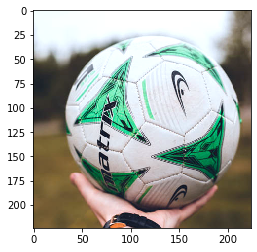

In [101]:
filepath = Path(M3_IMAGES, 'erik-mclean-D23_XPbsx-8-unsplash.jpg')
pred_proba = classifier.classify(filepath)
np.testing.assert_almost_equal(pred_proba, 2.0355723e-05, decimal=3)


[6.20066914e-11 2.11125735e-11 2.06483372e-11 2.16750978e-10
 9.24835000e-11 2.12060966e-10 8.21068352e-11 7.32108610e-11
 5.73086543e-11 3.54844626e-11 1.02123393e-10 1.61978653e-10
 4.58580743e-11 4.41030441e-11 1.65313013e-10 1.39299156e-10
 1.78012119e-10 1.65024772e-10 1.38600020e-10 6.98677574e-11
 1.20270655e-10 8.66726552e-11 8.28978830e-11 1.11146065e-10
 8.42380263e-11 1.53601194e-11 2.36780567e-10 3.78188626e-11
 1.87923260e-10 5.46930626e-11 4.32320360e-11 4.39272507e-11
 4.17685088e-11 1.92044176e-11 9.39781253e-10 2.53710303e-10
 2.24960901e-11 1.60418519e-11 1.63245334e-10 5.63404809e-11
 5.12038675e-11 2.19521915e-10 1.11092233e-10 2.70055575e-11
 3.59781475e-11 9.93500282e-11 2.36401367e-11 8.69974440e-11
 1.39318820e-10 4.52504735e-11 1.26663860e-10 2.19875056e-11
 8.57897642e-11 3.09200027e-11 9.78099407e-11 1.05609799e-10
 7.37159916e-11 6.02519423e-11 5.74182854e-11 7.76370218e-11
 8.79170625e-11 7.81615050e-11 4.35306548e-11 2.48943973e-11
 1.94352520e-10 6.99305

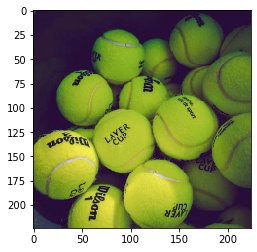

In [102]:
filepath = Path(M3_IMAGES, 'marvin-ronsdorf-CA998Anw2Lg-unsplash.jpg')
pred_proba = classifier.classify(filepath)
np.testing.assert_almost_equal(pred_proba, 0.9988895, decimal=3)